In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def alt_spectres(new_spec_wavs, old_spec_wavs, spec_fluxes, spec_errs=None):
    mytest = 0
    
    # Arrays of left-hand sides and widths for the old and new bins
    spec_lhs = np.zeros(old_spec_wavs.shape[0])
    spec_widths = np.zeros(old_spec_wavs.shape[0])
    spec_lhs[0] = old_spec_wavs[0]
    spec_lhs[0] -= (old_spec_wavs[1] - old_spec_wavs[0])/2
    spec_widths[-1] = (old_spec_wavs[-1] - old_spec_wavs[-2])
    spec_lhs[1:] = (old_spec_wavs[1:] + old_spec_wavs[:-1])/2
    spec_widths[:-1] = spec_lhs[1:] - spec_lhs[:-1]

    filter_lhs = np.zeros(new_spec_wavs.shape[0]+1)
    filter_widths = np.zeros(new_spec_wavs.shape[0])
    filter_lhs[0] = new_spec_wavs[0]
    filter_lhs[0] -= (new_spec_wavs[1] - new_spec_wavs[0])/2
    filter_widths[-1] = (new_spec_wavs[-1] - new_spec_wavs[-2])
    filter_lhs[-1] = new_spec_wavs[-1]
    filter_lhs[-1] += (new_spec_wavs[-1] - new_spec_wavs[-2])/2
    filter_lhs[1:-1] = (new_spec_wavs[1:] + new_spec_wavs[:-1])/2
    filter_widths[:-1] = filter_lhs[1:-1] - filter_lhs[:-2]
    fake_spec_wavs = new_spec_wavs

    if filter_lhs[0] < spec_lhs[0] or filter_lhs[-1] > spec_lhs[-1]:
        if filter_lhs[0] < spec_lhs[0]:
            mytest = 1
            new_spec_wavs = np.arange(old_spec_wavs[0],fake_spec_wavs[-1],(new_spec_wavs[1]-new_spec_wavs[0]))
        if filter_lhs[-1] > spec_lhs[-1]:
            mytest = 2
            new_spec_wavs = np.arange(fake_spec_wavs[0],old_spec_wavs[-1],(new_spec_wavs[1]-new_spec_wavs[0]))
            
        filter_lhs = np.zeros(new_spec_wavs.shape[0]+1)
        filter_widths = np.zeros(new_spec_wavs.shape[0])
        filter_lhs[0] = new_spec_wavs[0]
        filter_lhs[0] -= (new_spec_wavs[1] - new_spec_wavs[0])/2
        filter_widths[-1] = (new_spec_wavs[-1] - new_spec_wavs[-2])
        filter_lhs[-1] = new_spec_wavs[-1]
        filter_lhs[-1] += (new_spec_wavs[-1] - new_spec_wavs[-2])/2
        filter_lhs[1:-1] = (new_spec_wavs[1:] + new_spec_wavs[:-1])/2
        filter_widths[:-1] = filter_lhs[1:-1] - filter_lhs[:-2]

    # Generate output arrays to be populated
    res_fluxes = np.zeros(spec_fluxes[..., 0].shape + new_spec_wavs.shape)
    
    if filter_lhs[0] < spec_lhs[0] and filter_lhs[-1] > spec_lhs[-1]:
        print('this seems more like a sign that the request is bad')

    if spec_errs is not None:
        if spec_errs.shape != spec_fluxes.shape:
            raise ValueError("If specified, spec_errs must be the same shape"
                             "as spec_fluxes.")
        else:
            res_fluxerrs = np.copy(res_fluxes)

    start = 0
    stop = 0

    # Calculate new flux and uncertainty values, loop over new bins
    print(spec_lhs.shape[0])
    print(filter_lhs.shape[0])
    for j in range(new_spec_wavs.shape[0]):

        # Find first old bin which is partially covered by the new bin
        while spec_lhs[start+1] <= filter_lhs[j]:
            start += 1

        # Find last old bin which is partially covered by the new bin
        while spec_lhs[stop-1] < filter_lhs[j-1]:
            stop += 1

        # If new bin is fully within one old bin these are the same
        if stop == start:

            res_fluxes[..., j] = spec_fluxes[..., start]
            if spec_errs is not None:
                res_fluxerrs[..., j] = spec_errs[..., start]

        # Otherwise multiply the first and last old bin widths by P_ij
        else:

            start_factor = ((spec_lhs[start+1] - filter_lhs[j])
                            / (spec_lhs[start+1] - spec_lhs[start]))

            end_factor = ((filter_lhs[j+1] - spec_lhs[stop])
                          / (spec_lhs[stop+1] - spec_lhs[stop]))

            spec_widths[start] *= start_factor
            spec_widths[stop] *= end_factor

            # Populate res_fluxes spectrum and uncertainty arrays
            f_widths = spec_widths[start:stop+1]*spec_fluxes[..., start:stop+1]
            res_fluxes[..., j] = np.sum(f_widths, axis=-1)
            res_fluxes[..., j] /= np.sum(spec_widths[start:stop+1])

            if spec_errs is not None:
                e_wid = spec_widths[start:stop+1]*spec_errs[..., start:stop+1]

                res_fluxerrs[..., j] = np.sqrt(np.sum(e_wid**2, axis=-1))
                res_fluxerrs[..., j] /= np.sum(spec_widths[start:stop+1])

            # Put back the old bin widths to their initial values for later use
            spec_widths[start] /= start_factor
            spec_widths[stop] /= end_factor
    
    if (mytest != 0):
        ires_fluxes = np.zeros(fake_spec_wavs.shape[0] - res_fluxes.shape[0])
        if (mytest == 1):
            des_fluxes = np.append(ires_fluxes,res_fluxes)
        elif (mytest == 2):
            des_fluxes = np.append(res_fluxes,ires_fluxes)
        return des_fluxes, fake_spec_wavs

    # If errors were supplied return the res_fluxes spectrum and error arrays
    elif spec_errs is not None:
        return res_fluxes, res_fluxerrs
    
    # Otherwise just return the res_fluxes spectrum array
    else:
        return res_fluxes

In [3]:
def spectres(new_spec_wavs, old_spec_wavs, spec_fluxes, spec_errs=None):

    # Arrays of left-hand sides and widths for the old and new bins
    spec_lhs = np.zeros(old_spec_wavs.shape[0])
    spec_widths = np.zeros(old_spec_wavs.shape[0])
    spec_lhs[0] = old_spec_wavs[0]
    spec_lhs[0] -= (old_spec_wavs[1] - old_spec_wavs[0])/2
    spec_widths[-1] = (old_spec_wavs[-1] - old_spec_wavs[-2])
    spec_lhs[1:] = (old_spec_wavs[1:] + old_spec_wavs[:-1])/2
    spec_widths[:-1] = spec_lhs[1:] - spec_lhs[:-1]

    filter_lhs = np.zeros(new_spec_wavs.shape[0]+1)
    filter_widths = np.zeros(new_spec_wavs.shape[0])
    filter_lhs[0] = new_spec_wavs[0]
    filter_lhs[0] -= (new_spec_wavs[1] - new_spec_wavs[0])/2
    filter_widths[-1] = (new_spec_wavs[-1] - new_spec_wavs[-2])
    filter_lhs[-1] = new_spec_wavs[-1]
    filter_lhs[-1] += (new_spec_wavs[-1] - new_spec_wavs[-2])/2
    filter_lhs[1:-1] = (new_spec_wavs[1:] + new_spec_wavs[:-1])/2
    filter_widths[:-1] = filter_lhs[1:-1] - filter_lhs[:-2]

    if filter_lhs[0] < spec_lhs[0] or filter_lhs[-1] > spec_lhs[-1]:
        raise ValueError("spectres: The new wavelengths specified must fall"
                         "within the range of the old wavelength values.")

    # Generate output arrays to be populated
    res_fluxes = np.zeros(spec_fluxes[..., 0].shape + new_spec_wavs.shape)

    if spec_errs is not None:
        if spec_errs.shape != spec_fluxes.shape:
            raise ValueError("If specified, spec_errs must be the same shape"
                             "as spec_fluxes.")
        else:
            res_fluxerrs = np.copy(res_fluxes)

    start = 0
    stop = 0

    # Calculate new flux and uncertainty values, loop over new bins
    for j in range(new_spec_wavs.shape[0]):

        # Find first old bin which is partially covered by the new bin
        while spec_lhs[start+1] <= filter_lhs[j]:
            start += 1

        # Find last old bin which is partially covered by the new bin
        while spec_lhs[stop+1] < filter_lhs[j+1]:
            stop += 1

        # If new bin is fully within one old bin these are the same
        if stop == start:

            res_fluxes[..., j] = spec_fluxes[..., start]
            if spec_errs is not None:
                res_fluxerrs[..., j] = spec_errs[..., start]

        # Otherwise multiply the first and last old bin widths by P_ij
        else:

            start_factor = ((spec_lhs[start+1] - filter_lhs[j])
                            / (spec_lhs[start+1] - spec_lhs[start]))

            end_factor = ((filter_lhs[j+1] - spec_lhs[stop])
                          / (spec_lhs[stop+1] - spec_lhs[stop]))

            spec_widths[start] *= start_factor
            spec_widths[stop] *= end_factor

            # Populate res_fluxes spectrum and uncertainty arrays
            f_widths = spec_widths[start:stop+1]*spec_fluxes[..., start:stop+1]
            res_fluxes[..., j] = np.sum(f_widths, axis=-1)
            res_fluxes[..., j] /= np.sum(spec_widths[start:stop+1])

            if spec_errs is not None:
                e_wid = spec_widths[start:stop+1]*spec_errs[..., start:stop+1]

                res_fluxerrs[..., j] = np.sqrt(np.sum(e_wid**2, axis=-1))
                res_fluxerrs[..., j] /= np.sum(spec_widths[start:stop+1])

            # Put back the old bin widths to their initial values for later use
            spec_widths[start] /= start_factor
            spec_widths[stop] /= end_factor

    # If errors were supplied return the res_fluxes spectrum and error arrays
    if spec_errs is not None:
        return res_fluxes, res_fluxerrs

    # Otherwise just return the res_fluxes spectrum array
    else:
        return res_fluxes

In [4]:
step = 0.2 # idk try a few different ones

red_panda = pd.read_csv('_old_data/efficiencies/grating_red_low_res.txt',sep=',')
blue_panda = pd.read_csv('_old_data/efficiencies/grating_blue_low_res.txt',sep=',')

old_wavs_red = np.dot(red_panda[red_panda.columns[0]],10) # 6313.91etc to 10500
old_flux_red = np.dot(red_panda[red_panda.columns[1]],10)
old_wavs_blue = np.dot(blue_panda[blue_panda.columns[0]],10) # 3500 to 6996.36etc
old_flux_blue = np.dot(blue_panda[blue_panda.columns[1]],10)

bad_wavs = np.arange(5000,9000,step) # out of range
bad_wavs2 = np.arange(7000,12000,step)
good_wavs = np.arange(old_wavs_red[0],9000,step)
good_wavs2 = np.arange(7000,old_wavs_red[-1],step)

print(bad_wavs.shape[0],bad_wavs2)

#new_flux_red = spectres(new_wavs,old_wavs_red,old_flux_red)
bad_flux_red, bad_wavs_red = alt_spectres(bad_wavs,old_wavs_red,old_flux_red)
bad_flux_red2, bad_wavs_red2 = alt_spectres(bad_wavs2,old_wavs_red,old_flux_red)

nonzero_flux_red = spectres(good_wavs,old_wavs_red,old_flux_red)
nonzero_flux_red2 = spectres(good_wavs2,old_wavs_red,old_flux_red)


20000 [ 7000.   7000.2  7000.4 ... 11999.4 11999.6 11999.8]
25
12467


C:\Users\root\Anaconda3\lib\site-packages\ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in true_divide


25
17502


IndexError: index 25 is out of bounds for axis 0 with size 25

NameError: name 'nonzero' is not defined

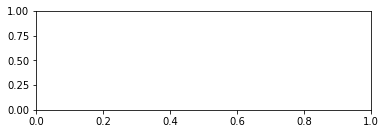

In [5]:
plt.subplot(2,1,1)
plt.plot(nonzero,nonzero_flux_red)
sum = np.trapz(nonzero_flux_red,nonzero)
print('normal:\t\t{}'.format(sum))

plt.subplot(2,1,2)
plt.plot(bad_wavs_red,bad_flux_red)
sum = np.trapz(bad_flux_red,bad_wavs_red)
print('modified:\t{}'.format(sum))

plt.subplot(2,2,1)
plt.plot(nonzero2,nonzero_flux_red2)
sum = np.trapz(nonzero_flux_red,nonzero)
print('normal:\t\t{}'.format(sum))

plt.subplot(2,2,2)
plt.plot(bad_wavs_red2,bad_flux_red2)
sum = np.trapz(bad_flux_red2,bad_wavs_red2)
print('modified:\t{}'.format(sum))

plt.show()